In [1]:
%load_ext autoreload
%autoreload 2

import particle as pt
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mplhep
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
import matplotlib.mlab as mlab
import time
from matplotlib.colors import LogNorm
import uproot.models
mplhep.style.use(mplhep.style.ROOT)
from pprint import pprint
from tqdm import tqdm
import polars as pl
import sys
import os
import particle
# using getlogin() returning username
user_name = os.getlogin()

sys.path.append(f'/home/{user_name}/Documents/cernbox/Atmos_Pandora/apc_atmo_repo/Anatree/')
from anatree_class import Anatree
from  ana_tools import *


plt.rcParams.update({'font.size': 23,
                     'grid.linestyle': '--',
                     'axes.grid': True,
                     'figure.autolayout': True,
                     'figure.figsize': [14,6]
                     })

anatree:Anatree
mcstree:uproot.models.TTree.Model_TTree_v20
mcsangle:pl.DataFrame
dfana:pl.DataFrame
def WIP(x=0.05, y=0.90, **kwargs):
    text = r"$\mathdefault{\bf{DUNE}}$" + " Work In Progress"
    plt.text(x, y, text,transform=plt.gca().transAxes, color="black", **kwargs)

In [2]:
import uproot.models
import uproot.models.TTree

def get_dump(fname):

    # mcstree:uproot.models.TTree.Model_TTree_v20
    mcstree = uproot.open(fname)

    arr={}
    
    alldata:ak.Array
    alldata = mcstree.arrays()
    top = len(alldata)

    klist = ['run','subrun','event','isContained','trkpdg', 'E']
    for c in klist:
        a  = alldata[c][:top]
        arr[c] = a
    tangles = pd.DataFrame(arr)
    dfret = pl.from_pandas(tangles)
    dfret = dfret.with_columns(
        p = (pl.col("E")**2 - 0.1057**2).sqrt()
    )
    return dfret


mcs = get_dump('../data/tracks_pdgcode_full.root:t1')

In [3]:
# import uproot.models
# import uproot.models.TTree

# def get_dump(fname):

#     # mcstree:uproot.models.TTree.Model_TTree_v20
#     mcstree = uproot.open(fname)

#     arr={}
    
#     alldata:ak.Array
#     alldata = mcstree.arrays()
#     top = len(alldata)

#     klist = ['run','subrun','event','isContained','len','trkpdg','E','Ereco','fitstatus' ]
#     nevts = [len(v) for v in alldata['azx'][:top]]
#     for c in klist:
#         if c in alldata.fields:
#             a  = alldata[c][:top]
#             arr[c] = np.repeat(a,nevts)
        
#     klist = ['azx','azy','avalid', 'Ei_true', 'ei']
#     for c in klist:
#         a  = alldata[c][:top]
#         arr[c] = ak.ravel(a)
    
#     tangles = pd.DataFrame(arr)
#     dfret = pl.from_pandas(tangles)
#     dfret = dfret.with_columns(
#         p = (pl.col("E")**2 - 0.1057**2).sqrt()
#     )
#     dfret = dfret.with_columns(
#         stepei = pl.col('ei'),
#         ei = (pl.col('ei').cum_count().over(selection_events()) - 1)*10
#     )
#     return dfret


# mcs = get_dump('../data/modified_chi2_llhd_chi2_no_angle_correction.root:t1')
# mcssoft = get_dump('../data/modified_chi2_llhd_chi2_no_angle_correction_llhd_soft.root:t1')

In [4]:
dfpdg = mcs.group_by(selection_events()).agg(
    pl.all().first()
).select(selection_events(['trkpdg','E', 'isContained']))

In [5]:
# dfpdg = dfpdg.group_by(selection_events()).agg(
#     pl.all().first()
# )
dfpdg

run,subrun,event,trkpdg,E,isContained
i32,i32,i32,i32,f64,bool
74251126,1,86177,13,0.250379,false
74525168,1,70862,13,0.268583,true
74506302,1,60909,13,1.32082,true
6419766,1,93185,13,0.200177,true
6432575,1,365,-13,2.507442,false
…,…,…,…,…,…
6419766,1,922,13,1.343438,false
50574832,1,116251,13,2.774801,false
74576447,1,34005,13,2.716137,false


In [6]:
anatree = Anatree("", load_data=False)
anatree.read_parquet('../data/parquet_anatree_modified_chi2_llhd_chi2_no_angle_correction/')

anatree_azx = Anatree("", load_data=False)
anatree_azx.read_parquet('../data/parquet_anatree_modified_main_and_llhd_azx_chi2_azy/')

anatreeo = Anatree("", load_data=False)
anatreeo.read_parquet('../data/parquet_anatree_original_reco2/')

anatreesoft = Anatree("", load_data=False)
anatreesoft.read_parquet('../data/parquet_verify_changes_to_retrieve_original/')


Reading nu files... 33/33
Reading geant files... 33/33



Reading nu files... 32/32
Reading geant files... 32/32
Reading reco_tracks files... 32/32

Reading pfp files... 32/32
Reading nu files... 32/32
Reading geant files... 32/32
Reading reco_tracks files... 32/32

Reading pfp files... 32/32
Reading nu files... 33/33
Reading geant files... 33/33
Reading reco_tracks files... 33/33

Reading pfp files... 33/33


In [7]:
def select_numu_cc(df:pl.DataFrame):
    df = df.filter(
        (pl.col('nuPDG_truth').abs() == 14) & (pl.col('ccnc_truth')==0)
    ).with_columns(
        E = (pl.col('lep_mom_truth')**2 + 0.1057**2).sqrt(),
        p = pl.col('lep_mom_truth'),
        Echi2 = pl.when(pl.col("RecoLepEnNumu_mcs_chi2")>-1).then(pl.col("RecoLepEnNumu_mcs_chi2")).otherwise(0.1),
        Ellhd = pl.when(pl.col("RecoLepEnNumu_mcs_llhd")>-1).then(pl.col("RecoLepEnNumu_mcs_llhd")).otherwise(0.1),
        Erange = pl.col('RecoLepEnNumu'),
    ).with_columns(
        pchi2 = (pl.col('Echi2')**2  - 0.1057**2).sqrt(),
        pllhd = (pl.col('Ellhd')**2  - 0.1057**2).sqrt(),
        prange = (pl.col('Erange')**2  - 0.1057**2).sqrt(),
        Ereco = pl.when(pl.col('LongestTrackContNumu')==1).then(pl.col('Erange')).otherwise(
            pl.col('Ellhd')
        ),
        Ereco2 = pl.when(pl.col('LongestTrackContNumu')==1).then(pl.col('Erange')).otherwise(
            # pl.when(pl.col('Echi2')>2).then(pl.col('Echi2')).otherwise(pl.col('Ellhd'))
            pl.when(pl.col('Echi2')>2).then(pl.max_horizontal('Echi2','Ellhd')).otherwise(pl.col('Ellhd'))
        )
    )
    return df
dfnu = select_numu_cc(anatree.nu.collect())
dfnu_azx = select_numu_cc(anatree_azx.nu.collect())
dfnuo = select_numu_cc(anatreeo.nu.collect())
dfnusoft = select_numu_cc(anatreesoft.nu.collect())


In [8]:
def adjust(df:pl.DataFrame):
    df = df.with_columns(
        isContained = pl.when(pl.col('Erange')==0).then(None).otherwise(
            pl.col('isContained')
        )
    ).filter(
        # ~pl.col('isContained').is_null(),
        pl.col('trkpdg').abs()==13
    )
    return df
    
df = dfnu.join(dfpdg, on=selection_events(), how="inner")
df_azx = dfnu_azx.join(dfpdg, on=selection_events(), how="inner")
dfo = dfnuo.join(dfpdg, on=selection_events(), how="inner")
dfsoft = dfnusoft.join(dfpdg, on=selection_events(), how="inner")
dfnone = dfnu.join(dfpdg, on=selection_events(), how='anti')


df = adjust(df)
df_azx = adjust(df_azx)
dfo = adjust(dfo)
dfsoft = adjust(dfsoft)

# df['LongestTrackContNumu', 'isContained','trkpdg','Erange', 'Ereco', 'E'].filter(
#     pl.col('LongestTrackContNumu')==-1,
#     True
# ).describe()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


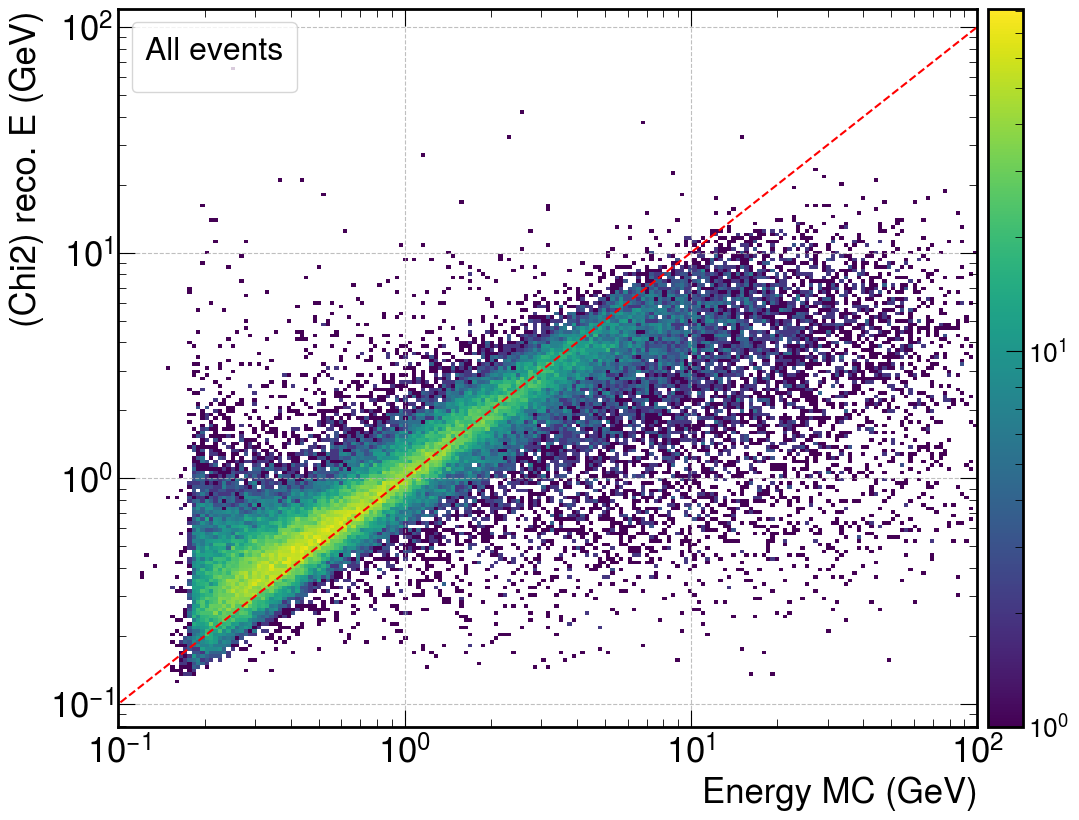

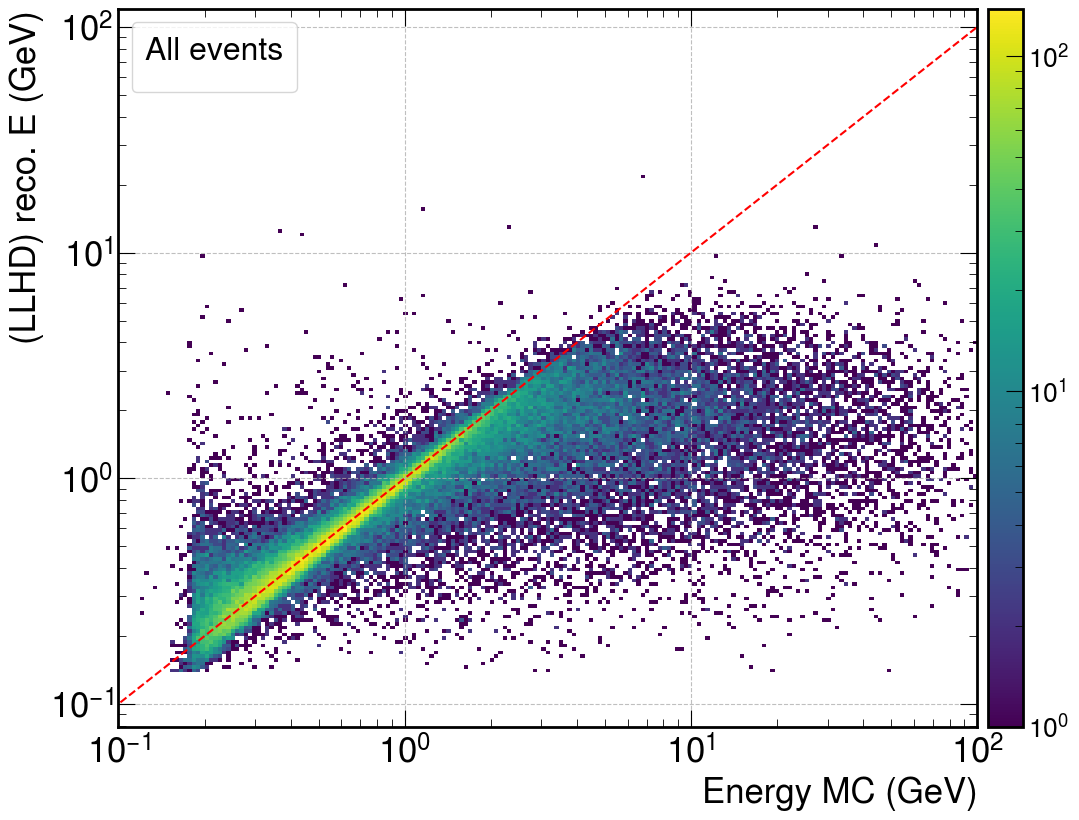

In [9]:
def plot_mu_vs_mu(Emu:pl.DataFrame, label, lmethod, x='E', y='RecoLepEnNumu', figsize=(12,8.7)):

    fig = plt.figure(figsize=figsize)
    # binsx = np.linspace(1,10,100)
    # binsy = np.linspace(1,10,100)
    binsx = np.logspace(-1,2,200)
    binsy = np.logspace(-1.1,np.log10(120),200)
    fontsize=25
    plt.hist2d(Emu[x],Emu[y], bins=(binsx,binsy), norm='log', cmin=1);
    # plt.plot([0,100],[0,100],'--', c='r')
    plt.xlabel('Energy MC (GeV)', fontsize=fontsize)
    plt.ylabel(f'{label} reco. E (GeV)', fontsize=fontsize)

    plt.yscale('log')
    plt.xscale('log')
    plt.tick_params(labelsize=fontsize)

    cbar = plt.colorbar(pad=0.01)
    # cbar.ax.set_ylabel('# of events', fontsize=fontsize)
    
    if lmethod != '':
        legend = plt.legend(frameon=True, title=lmethod, loc='upper left', bbox_to_anchor=(0,0.1,1,0.9))
        plt.setp(legend.get_title(),fontsize='medium')
    plt.plot([0,100],[0,100], 'r--')

plot_mu_vs_mu(df,  y='Echi2', label='(Chi2)', lmethod='All events')
plot_mu_vs_mu(df,  y='Ellhd', label='(LLHD)', lmethod='All events')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


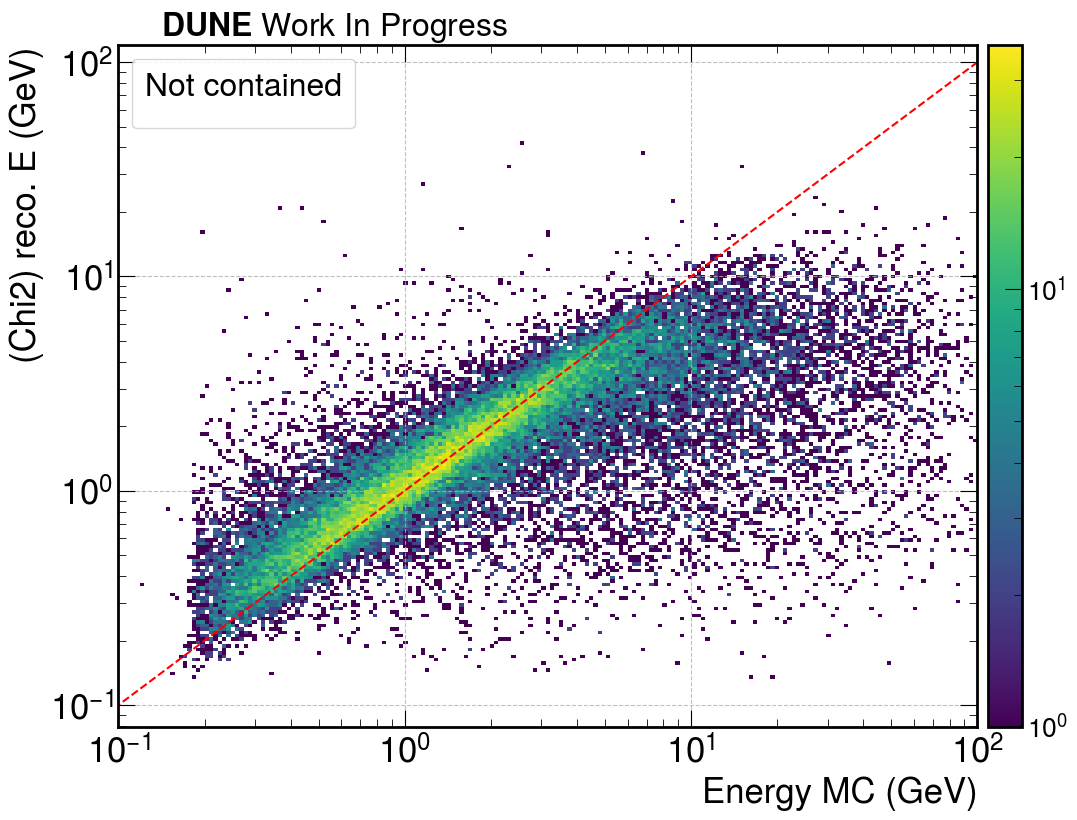

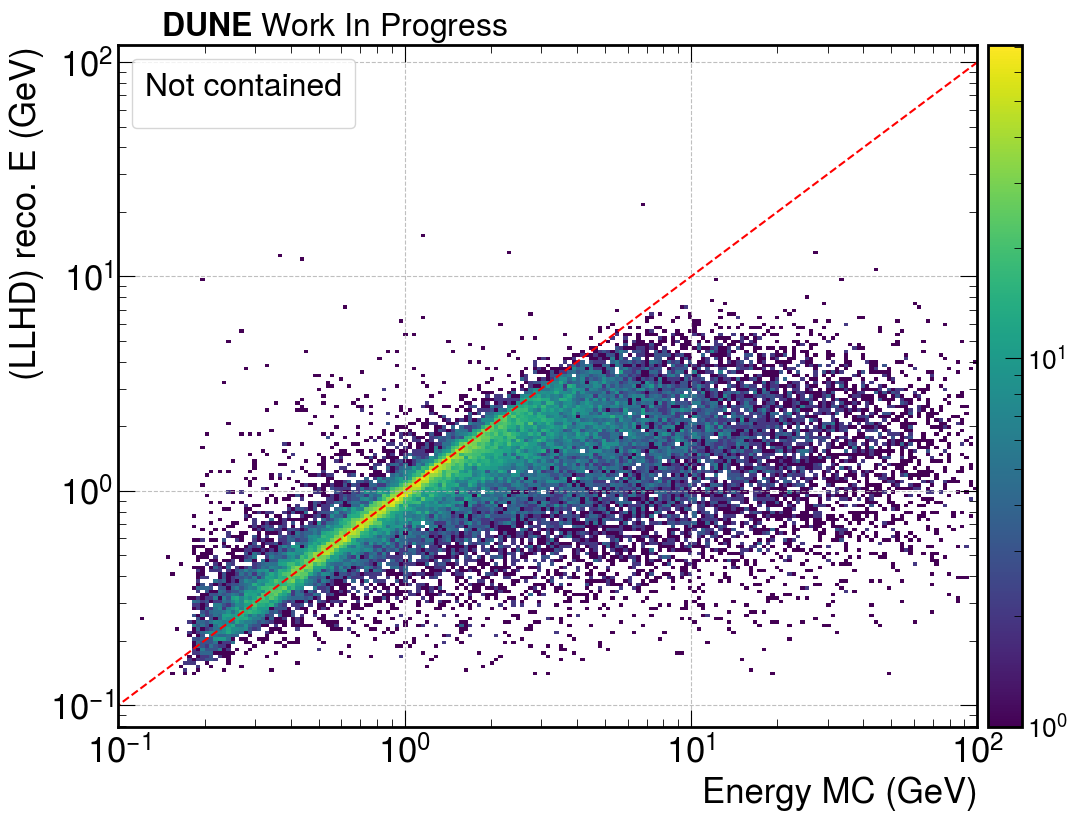

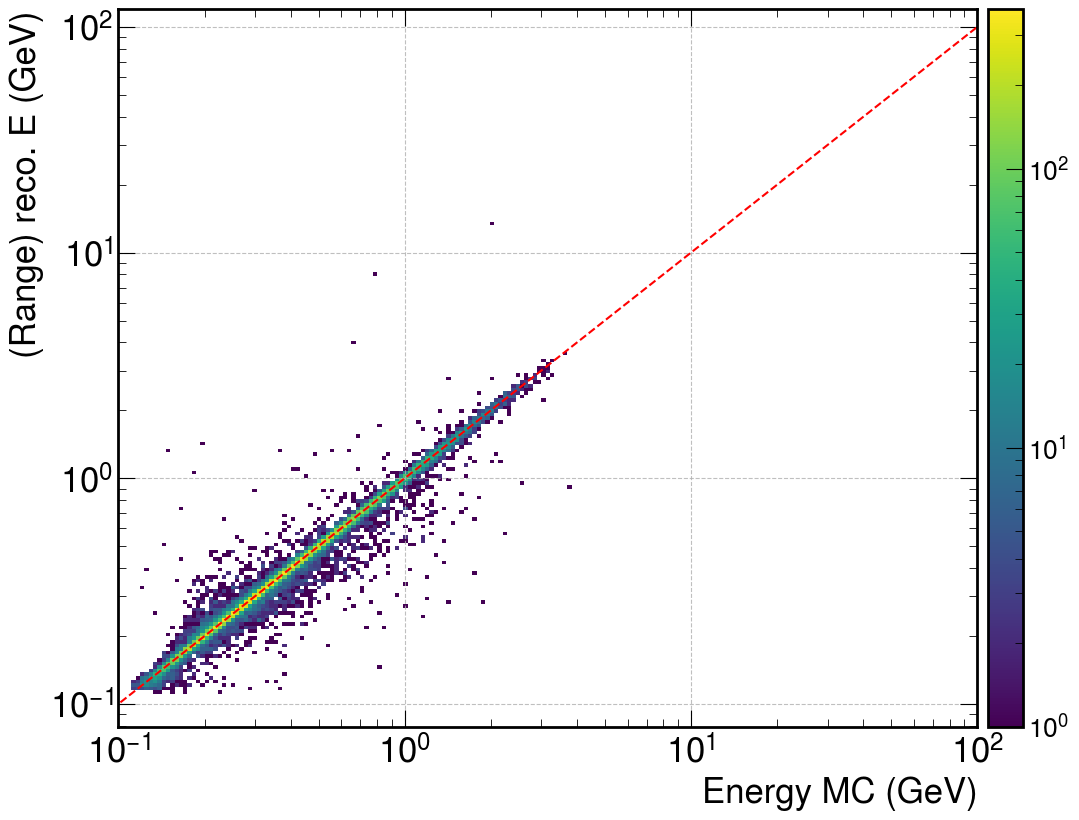

In [10]:

plot_mu_vs_mu(df.filter(~pl.col('isContained')),  y='Echi2', label='(Chi2)', lmethod='Not contained')
WIP(y=1.015)
plot_mu_vs_mu(df.filter(~pl.col('isContained')),  y='Ellhd', label='(LLHD)', lmethod='Not contained')
WIP(y=1.015)
plot_mu_vs_mu(dfo.filter(pl.col('isContained')),  y='Erange', label='(Range)', lmethod='')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


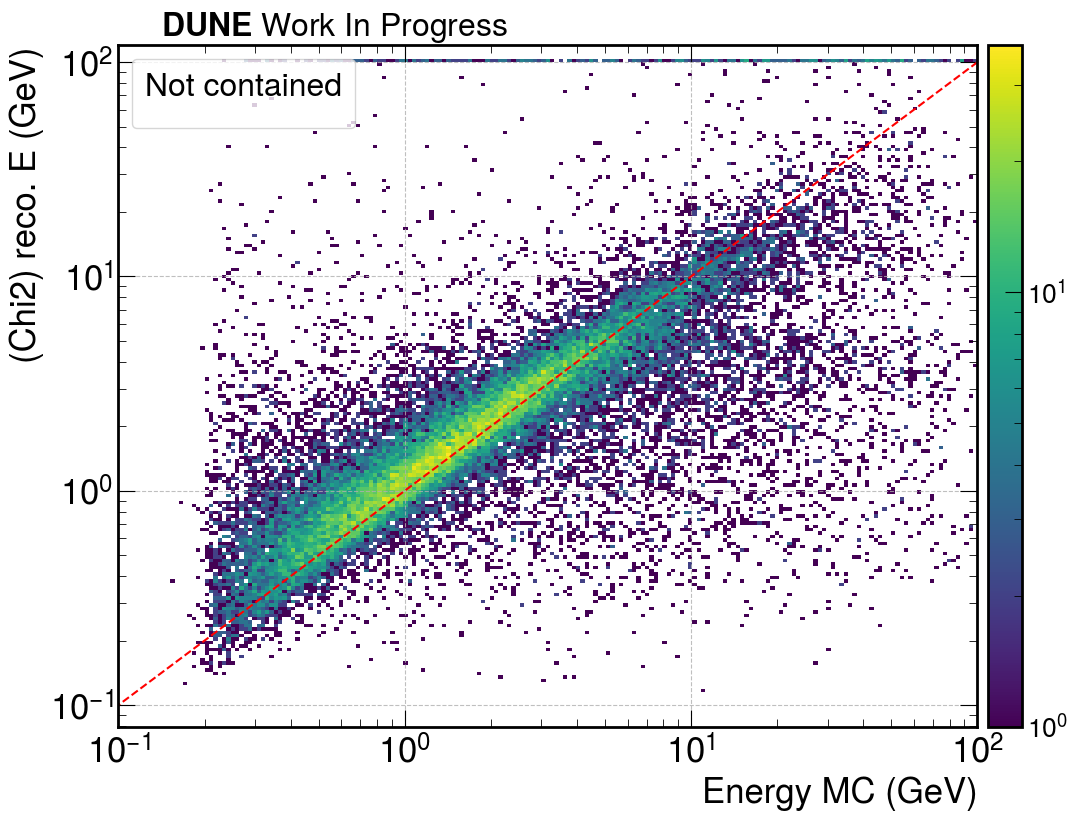

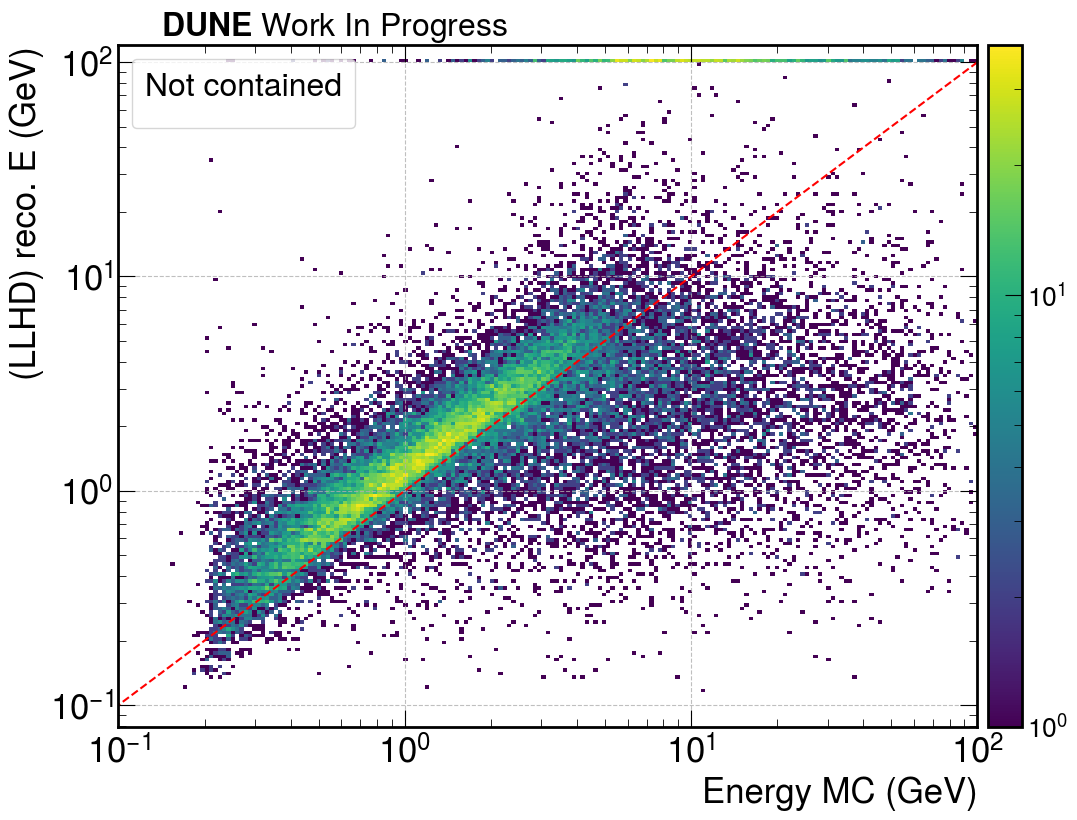

In [11]:
plot_mu_vs_mu(dfo.filter(~pl.col('isContained')),  y='Echi2', label='(Chi2)', lmethod='Not contained')
WIP(y=1.015)
# plot_mu_vs_mu(dfsoft.filter(~pl.col('isContained')),  y='Echi2', label='(Chi2)', lmethod='Not contained')
plot_mu_vs_mu(dfo.filter(~pl.col('isContained')),  y='Ellhd', label='(LLHD)', lmethod='Not contained')
WIP(y=1.015)
# plot_mu_vs_mu(dfsoft.filter(~pl.col('isContained')),  y='Ellhd', label='(LLHD)', lmethod='Not contained')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


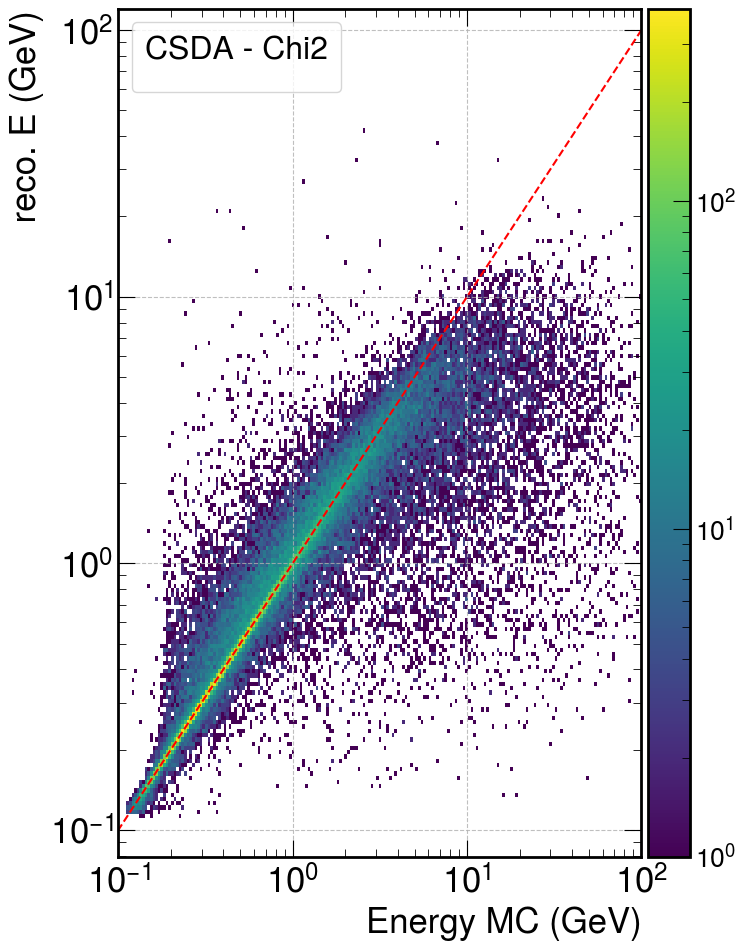

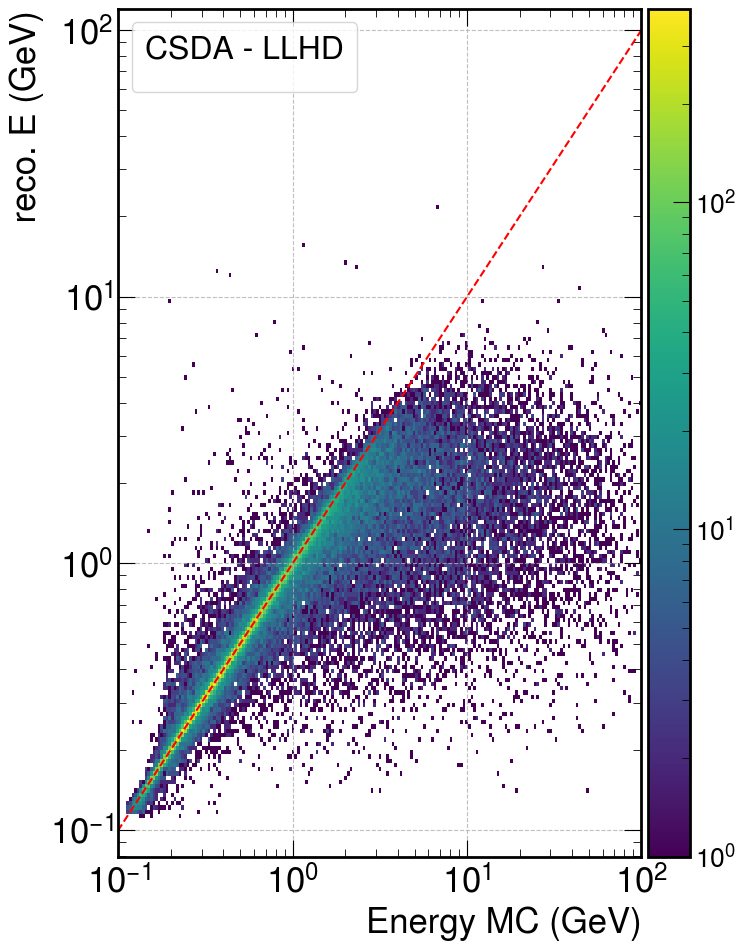

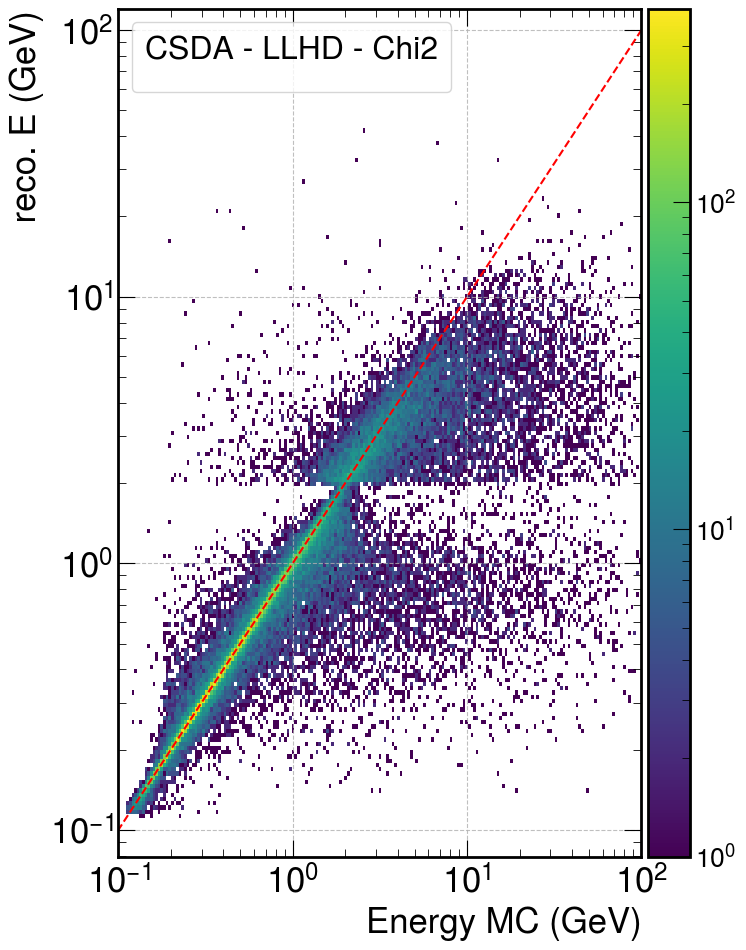

In [12]:
plot_mu_vs_mu(df,  y='RecoLepEnNumu', label='', lmethod='CSDA - Chi2', figsize=(8,10))
plot_mu_vs_mu(df,  y='Ereco', label='', lmethod='CSDA - LLHD', figsize=(8,10))
plot_mu_vs_mu(df,  y='Ereco2', label='', lmethod='CSDA - LLHD - Chi2', figsize=(8,10))

In [13]:
from scipy.stats import binned_statistic
def plot_res_scatter(x,
                    y,
                    actualx = None,
                    binsx = np.logspace(-1,2,200),
                    xlabel = 'True Muon Energy [GeV]',
                    ylabel = '',
                    makefrac = True,
                    fmt='.',
                    infotype='std',
                    xscale='log',
                    yscale='linear',
                    loc='best',
                    leg_ancor=None,
                    title='',
                    **kwargs):
    plotx = x.to_numpy()
    if not actualx is None:
        plotx = [v for v in actualx]
    if makefrac:
        ploty = (y/x-1).to_numpy()
        # ploty = (x/y-1).to_numpy()
        # plotx = plotx[y>0]
        # ploty = ploty[y>0]
    else:
        ploty = y
    if infotype=='std':
        val, _, _ = binned_statistic(plotx, ploty, manual_std, binsx)
        val*=100
        std, _, _ = binned_statistic(plotx, ploty, 'std', binsx)
        counts, _, _ = binned_statistic(plotx, ploty, 'count', binsx)
        val[counts<=2] = np.nan
        yerr = np.array([s*100/np.sqrt(2*c-1) if c>1 else 0 for s,c in zip(std,counts)])
        yerr = np.sqrt(yerr**2 + 0**2)
        if ylabel == '':
            ylabel = r'Resolution [%]'
        if title=='':
            title = r'1$\sigma\times$100'
    else:
        val, _, _ = binned_statistic(plotx, ploty, infotype, binsx)
        std, _, _ = binned_statistic(plotx, ploty, 'std', binsx)
        counts, _, _ = binned_statistic(plotx, ploty, 'count', binsx)
        val[counts<=2] = np.nan
        yerr = [s/np.sqrt(c) if c>1 else 0 for s,c in zip(std,counts)]
        if ylabel == '':
            ylabel = r'$E_{reco}/E_{true}-1$'
        if title=='':
            title = 'Mean'
    bins_center = 0.5*(binsx[:-1] + binsx[1:])
    bins_width = binsx[1:]- binsx[:-1]
    ax:plt.Axes
    ax = plt.gca()
    if 'capsize' in kwargs.keys():
        ax.errorbar(bins_center, val, xerr=(bins_width)/2, yerr=yerr, fmt=fmt, markersize=10, **kwargs)
    else:
        ax.plot(bins_center, val, fmt, **kwargs)
    plt.ylabel(ylabel,  )
    plt.xlabel(xlabel, )
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    legend = plt.legend(frameon=True, fancybox=False, bbox_to_anchor=leg_ancor,title=title, loc=loc)#, fontsize='large', title_fontsize='large')
    legend.get_frame().set_edgecolor('k')
    legend.get_frame().set_linewidth(0.6)
    plt.xlim(binsx[0],binsx[-1])
    plt.sca(ax)

(0.0, 100.0)

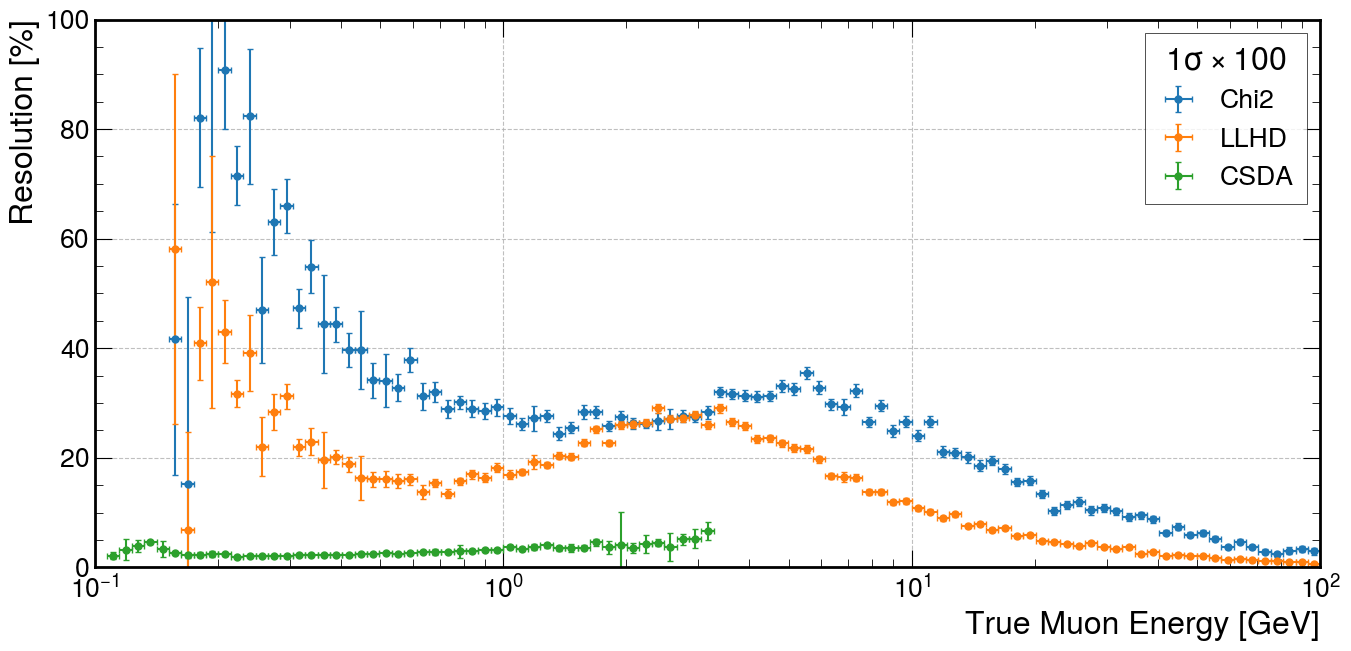

In [14]:
binsx= np.logspace(-1,2,100)
xscale='log'
binsx=binsx
capsize=2
label='LLHD'
plt.figure(figsize=(14,7))
plot_res_scatter(
    df.filter(~pl.col('isContained'))['E'],
    df.filter(~pl.col('isContained'))['Echi2'],
    xscale=xscale,
    binsx=binsx,
    capsize=capsize,
    label="Chi2",
)
plot_res_scatter(
    df.filter(~pl.col('isContained'))['E'],
    df.filter(~pl.col('isContained'))['Ellhd'],
    xscale=xscale,
    binsx=binsx,
    capsize=capsize,
    label=label,
)
plot_res_scatter(
    dfo.filter(pl.col('isContained'))['E'],
    dfo.filter(pl.col('isContained'))['Erange'],
    xscale=xscale,
    binsx=binsx,
    capsize=capsize,
    label="CSDA",
)

plt.ylim(0,100)


(-1.0, 1.0)

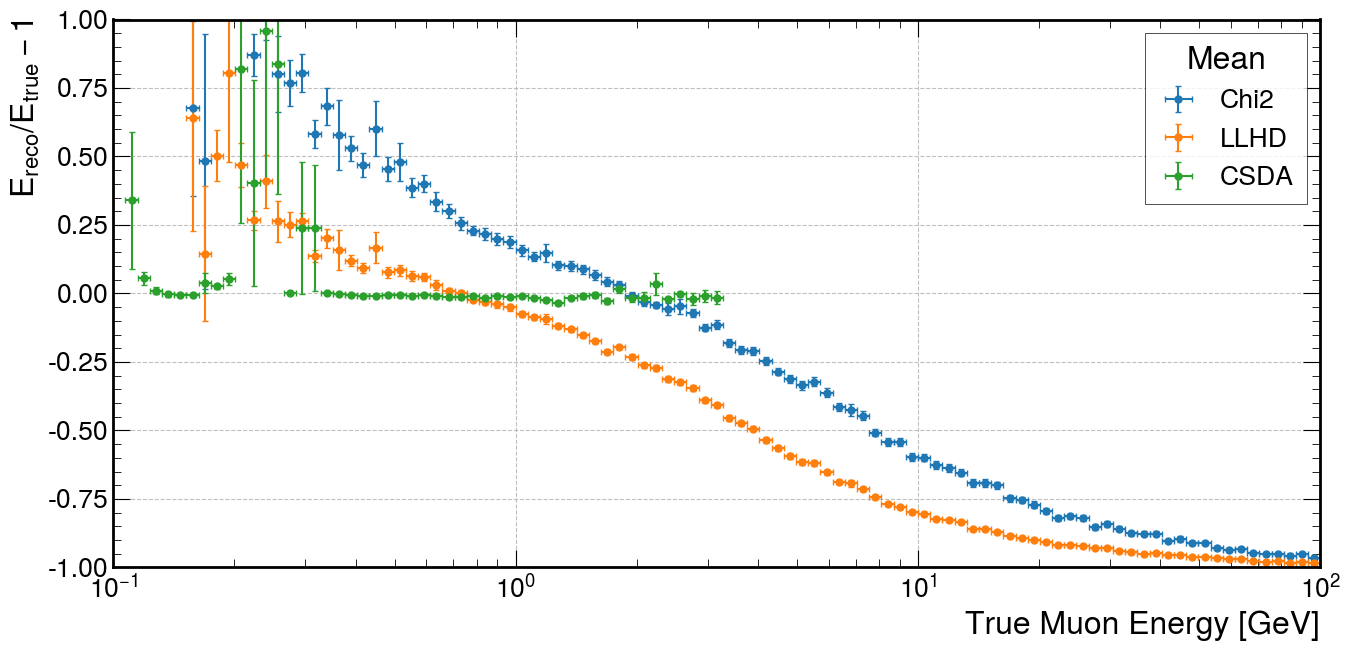

In [15]:
plt.figure(figsize=(14,7))
plot_res_scatter(
    df.filter(~pl.col('isContained'))['E'],
    df.filter(~pl.col('isContained'))['Echi2'],
    infotype="mean",
    xscale=xscale,
    binsx=binsx,
    capsize=capsize,
    label="Chi2",
)
plot_res_scatter(
    df.filter(~pl.col('isContained'))['E'],
    df.filter(~pl.col('isContained'))['Ellhd'],
    infotype="mean",
    xscale=xscale,
    binsx=binsx,
    capsize=capsize,
    label=label,
)

plot_res_scatter(
    dfsoft.filter(pl.col('isContained'))['E'],
    dfsoft.filter(pl.col('isContained'))['Erange'],
    infotype="mean",
    xscale=xscale,
    binsx=binsx,
    capsize=capsize,
    label="CSDA",
)
plt.ylim(-1,1)

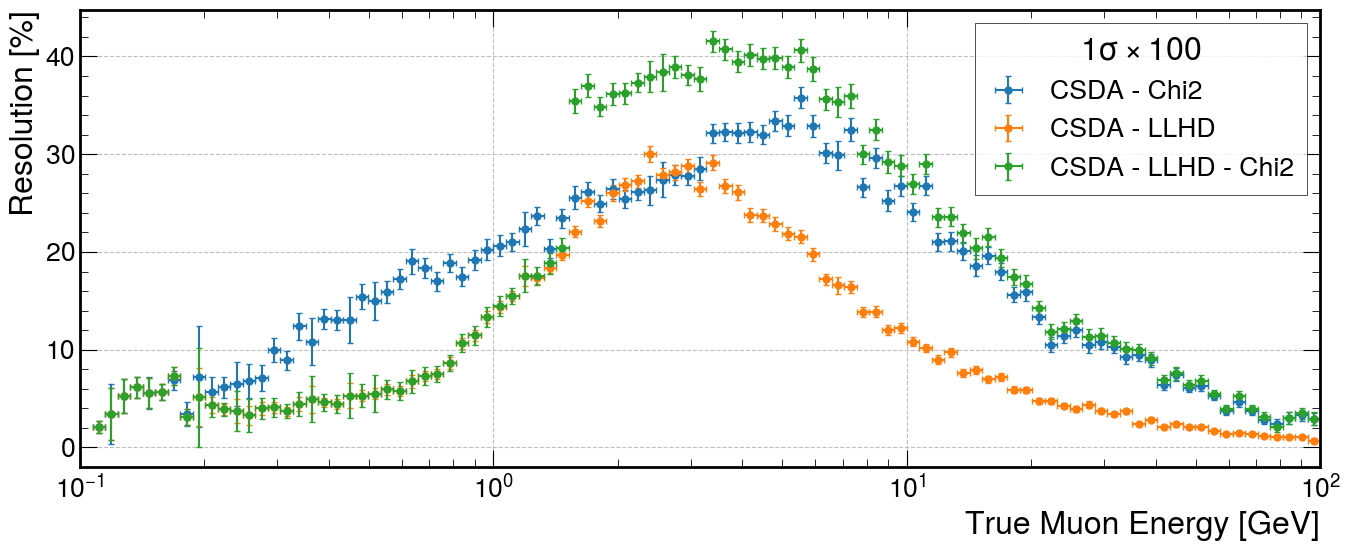

In [16]:
binsx= np.logspace(-1,2,100)
xscale='log'
binsx=binsx
capsize=2
loc='upper right'
plot_res_scatter(
    df['E'],
    df['RecoLepEnNumu'],
    xscale=xscale,
    binsx=binsx,
    capsize=capsize,
    label="CSDA - Chi2",
    loc=loc,
)
plot_res_scatter(
    df['E'],
    df['Ereco'],
    xscale=xscale,
    binsx=binsx,
    capsize=capsize,
    label="CSDA - LLHD",
    loc=loc,
)
plot_res_scatter(
    df['E'],
    df['Ereco2'],
    xscale=xscale,
    binsx=binsx,
    capsize=capsize,
    label="CSDA - LLHD - Chi2",
    loc=loc,
)


(-1.0, 0.4)

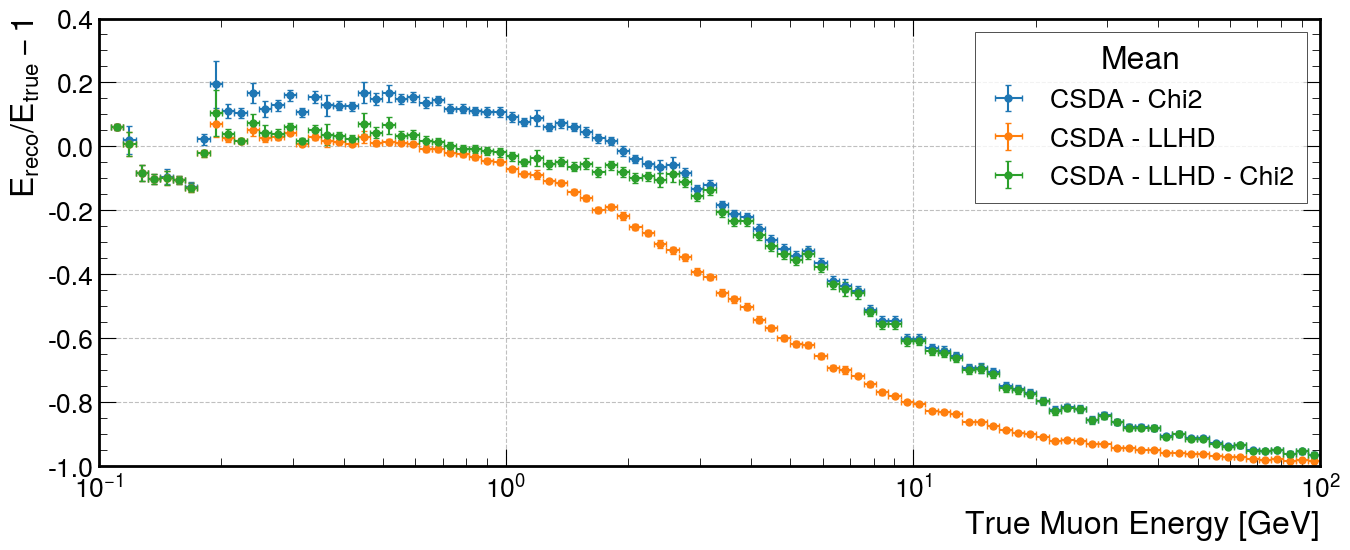

In [17]:

plot_res_scatter(
    df['E'],
    df['RecoLepEnNumu'],
    infotype='mean',
    xscale=xscale,
    binsx=binsx,
    capsize=capsize,
    label="CSDA - Chi2",
)
plot_res_scatter(
    df['E'],
    df['Ereco'],
    infotype='mean',
    xscale=xscale,
    binsx=binsx,
    capsize=capsize,
    label="CSDA - LLHD",
)
plot_res_scatter(
    df['E'],
    df['Ereco2'],
    infotype='mean',
    xscale=xscale,
    binsx=binsx,
    capsize=capsize,
    label="CSDA - LLHD - Chi2",
)
plt.ylim(-1,0.4)

(-1.0, 200.0)

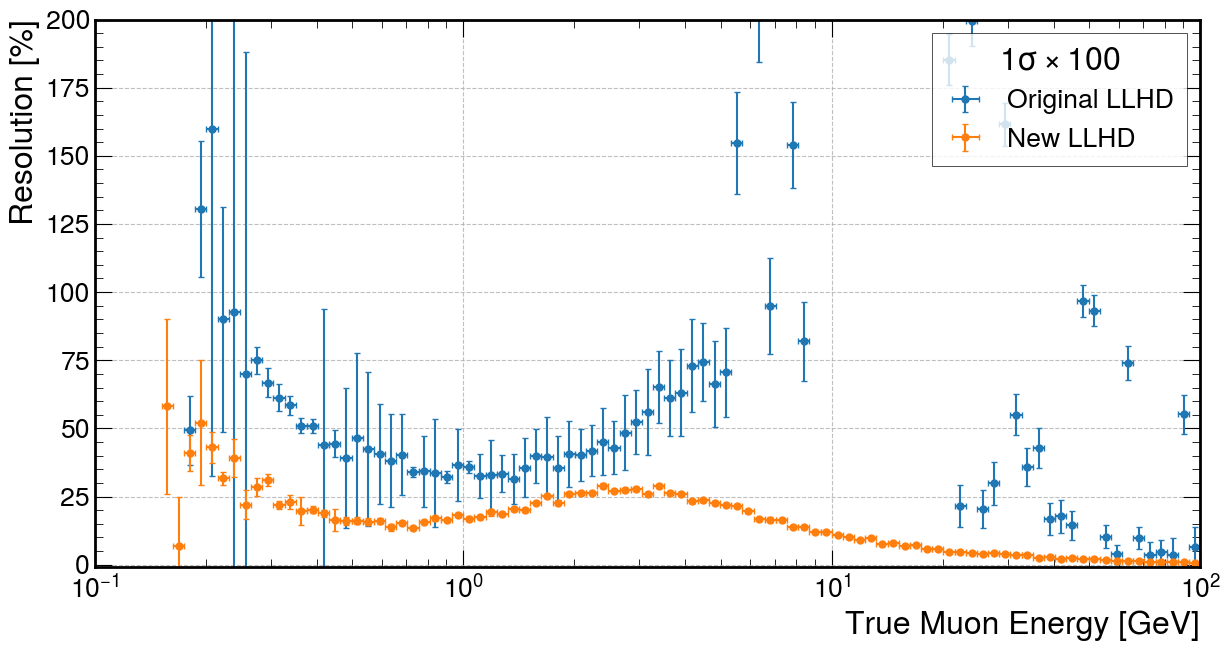

In [48]:
plt.figure(figsize=(12.8,7))
binsx= np.logspace(-1,2,100)
xscale='log'
binsx=binsx
capsize=2
loc='upper right'
plot_res_scatter(
    dfo.filter(pl.col("LongestTrackContNumu")==0)['E'],
    dfo.filter(pl.col("LongestTrackContNumu")==0)['Ellhd'],
    xscale=xscale,
    binsx=binsx,
    capsize=capsize,
    label="Original LLHD",
    loc=loc,
)
plot_res_scatter(
    df.filter(pl.col("LongestTrackContNumu")==0)['E'],
    df.filter(pl.col("LongestTrackContNumu")==0)['Ellhd'],
    xscale=xscale,
    binsx=binsx,
    capsize=capsize,
    label="New LLHD",
    loc=loc,
)
plt.ylim(-1,200)


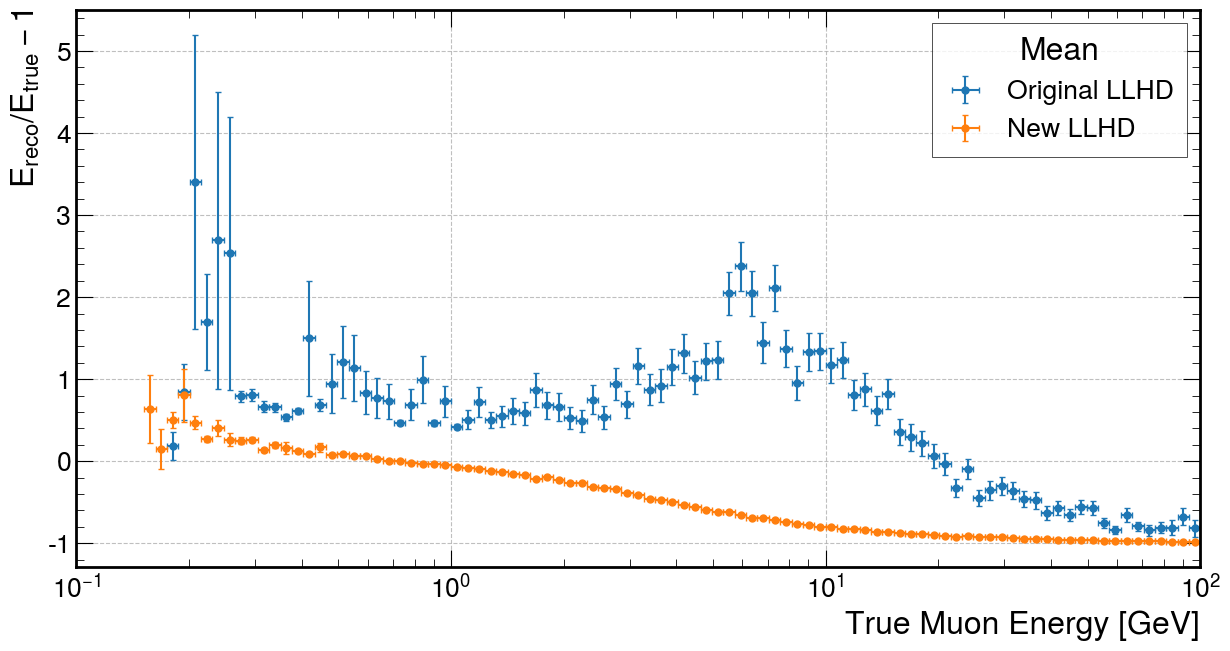

In [49]:
plt.figure(figsize=(12.8,7))
plot_res_scatter(
    dfo.filter(pl.col("LongestTrackContNumu")==0)['E'],
    dfo.filter(pl.col("LongestTrackContNumu")==0)['Ellhd'],
    infotype='mean',
    xscale=xscale,
    binsx=binsx,
    capsize=capsize,
    label="Original LLHD",
    loc=loc,
)
plot_res_scatter(
    df.filter(pl.col("LongestTrackContNumu")==0)['E'],
    df.filter(pl.col("LongestTrackContNumu")==0)['Ellhd'],
    infotype='mean',
    xscale=xscale,
    binsx=binsx,
    capsize=capsize,
    label="New LLHD",
    loc=loc,
)


(-1.0, 200.0)

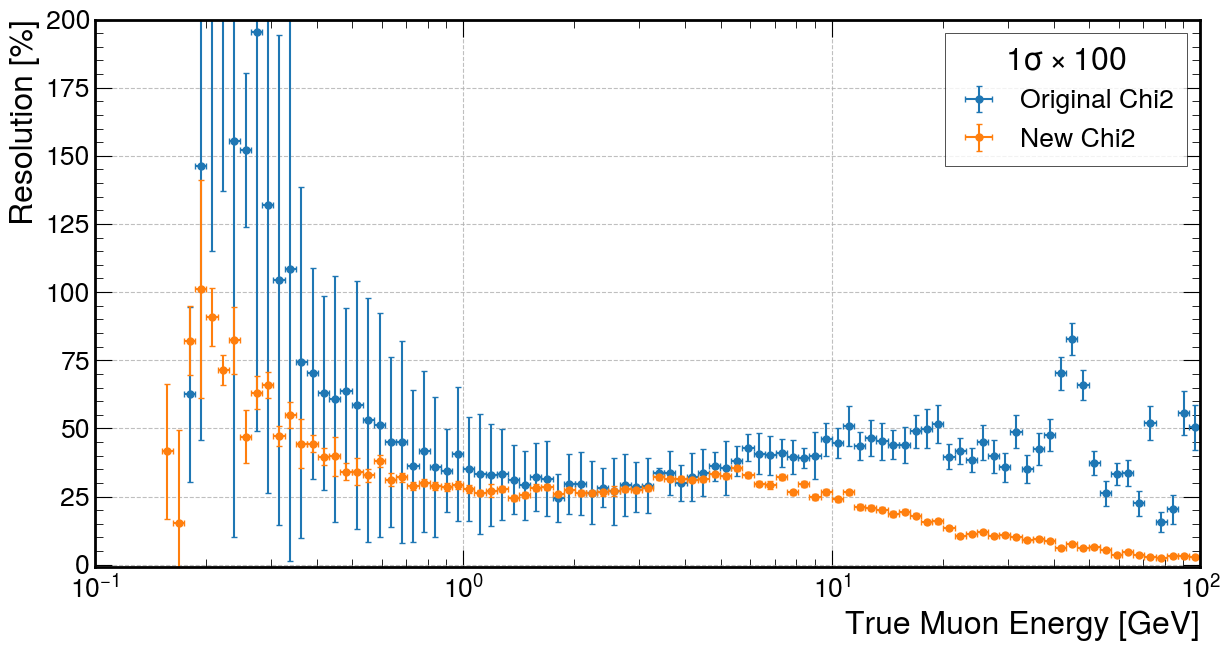

In [47]:
plt.figure(figsize=(12.8,7))
binsx= np.logspace(-1,2,100)
xscale='log'
binsx=binsx
capsize=2
loc='upper right'
plot_res_scatter(
    dfo.filter(pl.col("LongestTrackContNumu")==0)['E'],
    dfo.filter(pl.col("LongestTrackContNumu")==0)['Echi2'],
    xscale=xscale,
    binsx=binsx,
    capsize=capsize,
    label="Original Chi2",
    loc=loc,
)
plot_res_scatter(
    df.filter(pl.col("LongestTrackContNumu")==0)['E'],
    df.filter(pl.col("LongestTrackContNumu")==0)['Echi2'],
    xscale=xscale,
    binsx=binsx,
    capsize=capsize,
    label="New Chi2",
    loc=loc,
)
plt.ylim(-1,200)

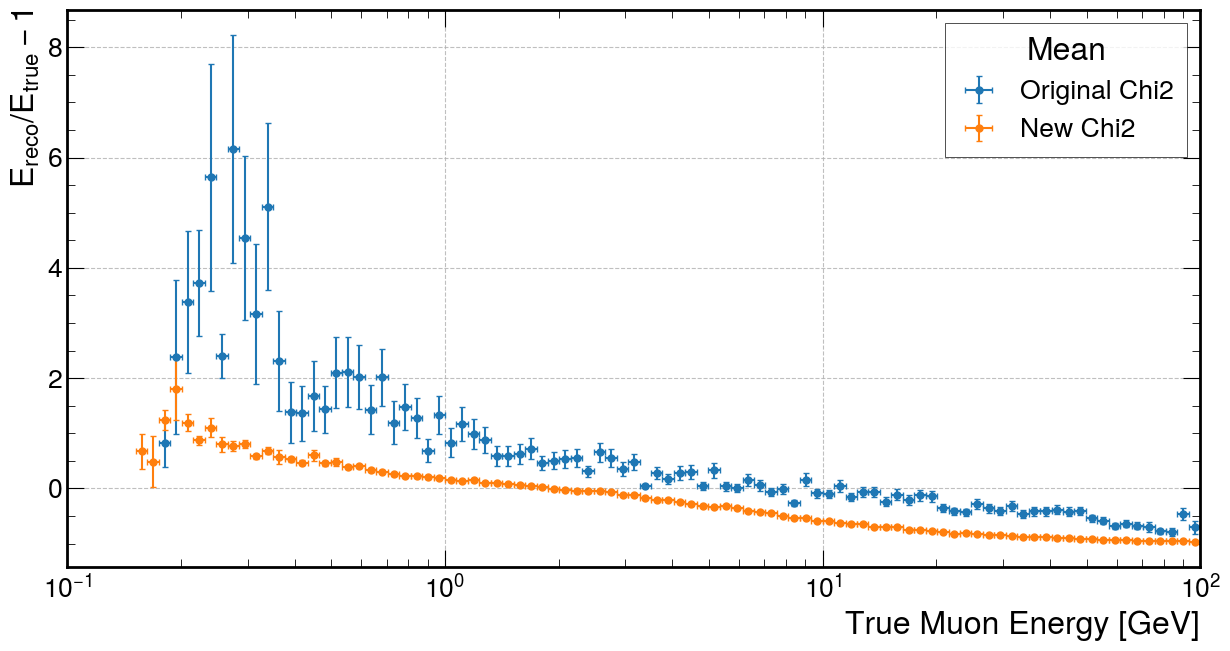

In [50]:
plt.figure(figsize=(12.8,7))
plot_res_scatter(
    dfo.filter(pl.col("LongestTrackContNumu")==0)['E'],
    dfo.filter(pl.col("LongestTrackContNumu")==0)['Echi2'],
    infotype='mean',
    xscale=xscale,
    binsx=binsx,
    capsize=capsize,
    label="Original Chi2",
    loc=loc,
)
plot_res_scatter(
    df.filter(pl.col("LongestTrackContNumu")==0)['E'],
    df.filter(pl.col("LongestTrackContNumu")==0)['Echi2'],
    infotype='mean',
    xscale=xscale,
    binsx=binsx,
    capsize=capsize,
    label="New Chi2",
    loc=loc,
)

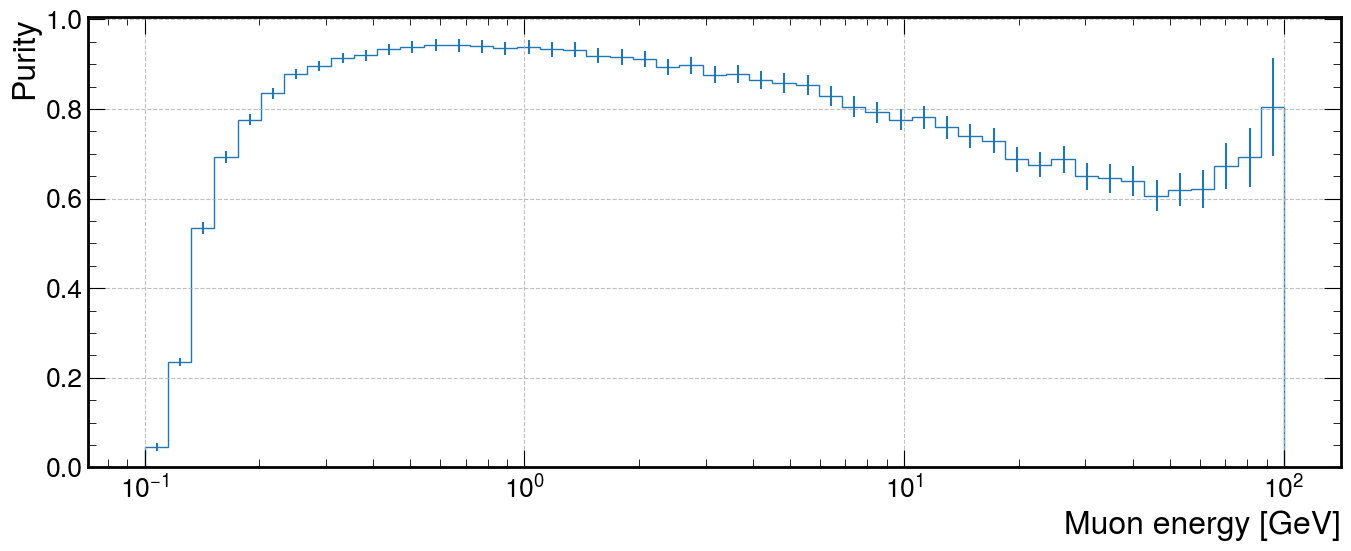

In [22]:
dfismu = dfpdg.filter(
    pl.col('trkpdg').abs()==13
)

def get_eff(htot,h):
    eff = h/htot
    ereff = eff*np.sqrt(1/h + 1/htot)
    return eff, ereff

def plot_eff(eff, ereff, xlabel):
    x = (binsx[1:]+binsx[:-1])*0.5
    p = plt.stairs(eff, binsx)
    plt.errorbar(x, eff, yerr=ereff, ls='none',marker='none', color=p.get_edgecolor())
    plt.xscale('log')
    plt.xlabel(xlabel)
    plt.ylabel('Purity')

binsx = np.logspace(-1,2,50)
plt.figure()
hmu, edgemu = np.histogram(dfpdg['E'], bins=binsx)
hismu, edgeismu = np.histogram(dfismu['E'], bins=binsx)

eff, ereff = get_eff(hmu, hismu)
plot_eff(eff,ereff, "Muon energy [GeV]")
